In [117]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import itertools 
from collections import defaultdict 
import ast
import sys
from collections import defaultdict
from PIL import Image

Please define your datasets here

In [129]:
DATASETS = {
    'US_DATA_PSEUDO': {
        'path': '/mnt/Synology/Liver/Ultrasound/US_DATA_PSEUDO',
        'classes': ['FNH', 'HCC', 'Hemangioma', 'Metastasis'],
        'color': ['#808080'], 
    }
    # Add more datasets as needed
    }

In [ ]:
def get_info_from_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    mean_frame_brightness = np.mean(gray)
    std_intensity = np.std(gray)
    speckle_index = calculate_speckle_index(mean_frame_brightness, std_intensity)

    return hist.flatten(), mean_frame_brightness, speckle_index

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    hist_sum = np.zeros(256, dtype=np.float64)
    frame_count = 0
    frame_mean_brightness_list = []
    frame_speckle_index_list = []
    num_pixels_list = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        hist, mean_brightness, speckle_index = get_info_from_image(frame)
        hist_sum += hist
        frame_count += 1
        frame_mean_brightness_list.append(mean_brightness)
        frame_speckle_index_list.append(speckle_index)
        num_pixels = get_num_pixels(frame)
        num_pixels_list.append(num_pixels)

    cap.release()
    return hist_sum, frame_mean_brightness_list, frame_speckle_index_list, num_pixels_list, frame_count

def process_image(image_path):
    image = cv2.imread(image_path)
    num_pixels = get_num_pixels(image)
    if image is None:
        print(f"Warning: Not able to load {image_path}.")
        return np.zeros(256), [], 0
    hist, mean_brightness, speckle_index = get_info_from_image(image)
    return hist, [mean_brightness], [speckle_index], [num_pixels], 1

def calculate_speckle_index(mean_intensity, std_intensity):
    if mean_intensity == 0 or np.isnan(mean_intensity) or np.isnan(std_intensity):
        return np.nan  # Avoiding division by 0 
    return std_intensity / mean_intensity

def get_num_pixels(image):
    if image is None:
        print(f"Warning: Not able to load {image}.")
        return 0
    height, width = image.shape[:2]
    return height * width

def process_dataset(dataset_name):    
    dataset_info = DATASETS.get(dataset_name)
    if not dataset_info:
        print(f"Dataset {dataset_name} not found.")
        return None

    dataset_path = dataset_info['path']
    classes = dataset_info['classes']
    color = dataset_info['color']

    data_rows = []
    brightness_hist = np.zeros(256, dtype=np.float64)

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_path):
            print(f"Class path {class_name} was not found in {dataset_path}.")
            continue
        
        brightness_hist_class = np.zeros(256, dtype=np.float64)

        for root, _, files in os.walk(class_path):
            for file in files:
                file_path = os.path.join(root, file)
                ext = file.split('.')[-1].lower()
                img_ext = ['jpg', 'jpeg', 'png', 'bmp', 'tiff']
                video_ext = ['mp4', 'avi', 'mov', 'mkv']
                if ext not in img_ext and ext not in video_ext:
                    continue

                row = {
                    "dataset": dataset_name,
                    "class": class_name,
                    "pat": os.path.basename(root),
                    "filepath": file_path,
                    "filetype": None,
                    "mean_brightness": None,
                    "speckle_index": None,
                    "num_pixels": None,
                    "frame_count": None,
                }

                try:
                    if ext in img_ext:
                        hist, brightness_list, speckle_list, pixel_list, count = process_image(file_path)
                        brightness_hist  += hist
                        brightness_hist_class += hist

                        row = {
                            "dataset": dataset_name,
                            "class": class_name,
                            "pat": os.path.basename(root),
                            "filepath": file_path,
                            "filetype": "image",
                            "frame_id": 1,
                            "mean_brightness": brightness_list[0] if brightness_list else None,
                            "speckle_index": speckle_list[0] if speckle_list else None,
                            "num_pixels": pixel_list[0] if pixel_list else None,
                            "frame_count": 1
                        }
                        data_rows.append(row)

                    elif ext in video_ext:
                        hist, brightness_list, speckle_list, pixel_list, count = process_video(file_path)
                        brightness_hist  += hist
                        brightness_hist_class += hist

                        for i in range(count):
                            row = {
                                "dataset": dataset_name,
                                "class": class_name,
                                "pat": os.path.basename(root),
                                "filepath": file_path,
                                "filetype": "video",
                                "frame_id": i+1,
                                "mean_brightness": brightness_list[i] if i < len(brightness_list) else None,
                                "speckle_index": speckle_list[i] if i < len(speckle_list) else None,
                                "num_pixels": pixel_list[i] if i < len(pixel_list) else None,
                                "frame_count": count
                            }
                            data_rows.append(row)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        # # Normalize brightness histogram
        # brightness_hist_class /= np.sum(brightness_hist_class) if np.sum(brightness_hist_class) > 0 else 1
        #     #Plot Class Histogram
        # plt.figure(figsize=(10,6))
        # plt.title(f"Brightness (of all pixels) histogram for class {class_name} in dataset {dataset_name}")
        # plt.xlabel("Brightness value (0=black, 255=white)")
        # plt.ylabel("Average frequency")
        # plt.bar(range(256), brightness_hist_class, width=1.0, color=color)
        # plt.show()

    brightness_hist /= np.sum(brightness_hist) if np.sum(brightness_hist) > 0 else 1
    #Plot  Histogram
    plt.figure(figsize=(10,6))
    plt.title(f"Brightness (of all pixels) histogram for dataset {dataset_name}")
    plt.xlabel("Brightness value (0=black, 255=white)")
    plt.ylabel("Average frequency")
    plt.bar(range(256), brightness_hist, width=1.0, color=color)
    plt.show() 
       
    # DataFrame erzeugen
    df = pd.DataFrame(data_rows)
    #print(df)

    # Infomation about the dataset
    print(f"Processed dataset: {dataset_name}")
    print(f"Total number of frames: {len(df)}")
    print(f"Average mean brightness for '{dataset_name}': {round(df['mean_brightness'].mean(),2) if not df.empty else 'N/A'}")
    print(f"Average speckle index for '{dataset_name}': {round(df['speckle_index'].mean(),2) if not df.empty else 'N/A'}")
    print(f"Patients in class '{dataset_name}': {df['pat'].nunique()}")

    print(f"Classes found: {', '.join(classes)}")
    print("----------------------")
    for class_name in classes:
        filtered_df = df[df['class'] == class_name]
        print(f"Class '{class_name}' has {len(filtered_df)} frames.")
        print(f"Average mean brightness for class '{class_name}': {round(filtered_df['mean_brightness'].mean(),2) if not filtered_df.empty else 'N/A'}")
        print(f"Average speckle index for class '{class_name}': {round(filtered_df['speckle_index'].mean(),2) if not filtered_df.empty else 'N/A'}")
        print(f"Patients in class '{class_name}': {filtered_df['pat'].nunique()}")
        
        # Mittelwerte der Helligkeit runden (auf ganze Graustufen)
        rounded_brightness = filtered_df["mean_brightness"].dropna().round().astype(int)

        # Histogramm erstellen: Zähle, wie oft jeder Wert (0–255) vorkommt
        brightness_counts = rounded_brightness.value_counts().sort_index()

        # Sicherstellen, dass alle Werte von 0 bis 255 abgedeckt sind
        full_range = pd.Series(0, index=range(256))  # alle Werte von 0 bis 255 mit 0 initialisieren
        brightness_counts = full_range.add(brightness_counts, fill_value=0)

        plt.figure(figsize=(10,6))
        plt.title(f"Frequency of average brightness in class '{class_name}'")
        plt.xlabel("Average brightness (0 = black, 255 = white)")
        plt.ylabel("Number of images/frames")
        plt.bar(brightness_counts.index, brightness_counts.values, width=1.0, color=color)
        plt.tight_layout()
        plt.show()
        plt.show() 
        print("----------------------")


    return df

def process_all_datasets():
    for dataset in DATASETS.keys():
        print("------------------------NEW DATASET------------------------")
        print(f"Processing dataset: {dataset}")
        dataset_summary = process_dataset(dataset)
        dataset_summary.to_csv(f"{dataset}_summary.csv", index=False)


# Get the first overview

------------------------NEW DATASET------------------------
Processing dataset: US_DATA_PSEUDO


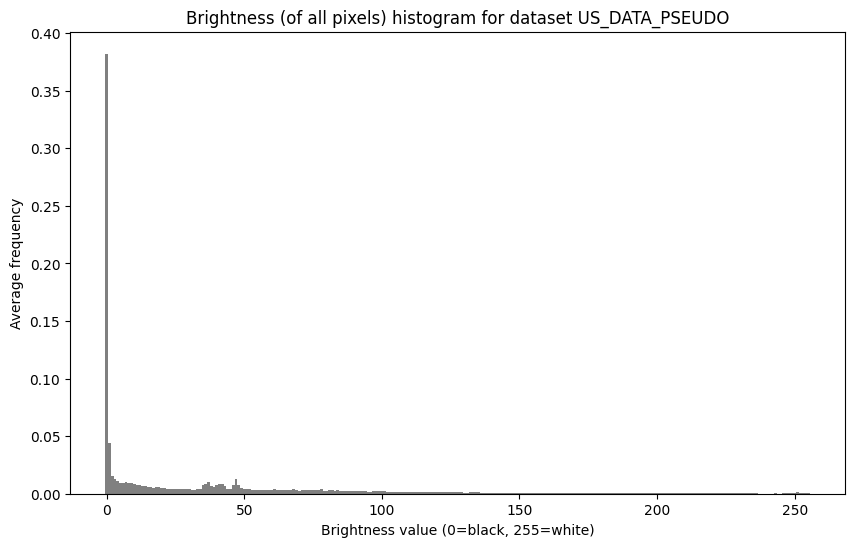

Processed dataset: US_DATA_PSEUDO
Total number of frames: 955938
Average mean brightness for 'US_DATA_PSEUDO': 33.69
Average speckle index for 'US_DATA_PSEUDO': 1.53
Patients in class 'Metastasis': 371
Classes found: FNH, HCC, Hemangioma, Metastasis
----------------------
Class 'FNH' has 115633 frames.
Average mean brightness for class 'FNH': 35.22
Average speckle index for class 'FNH': 1.55
Patients in class 'FNH': 53


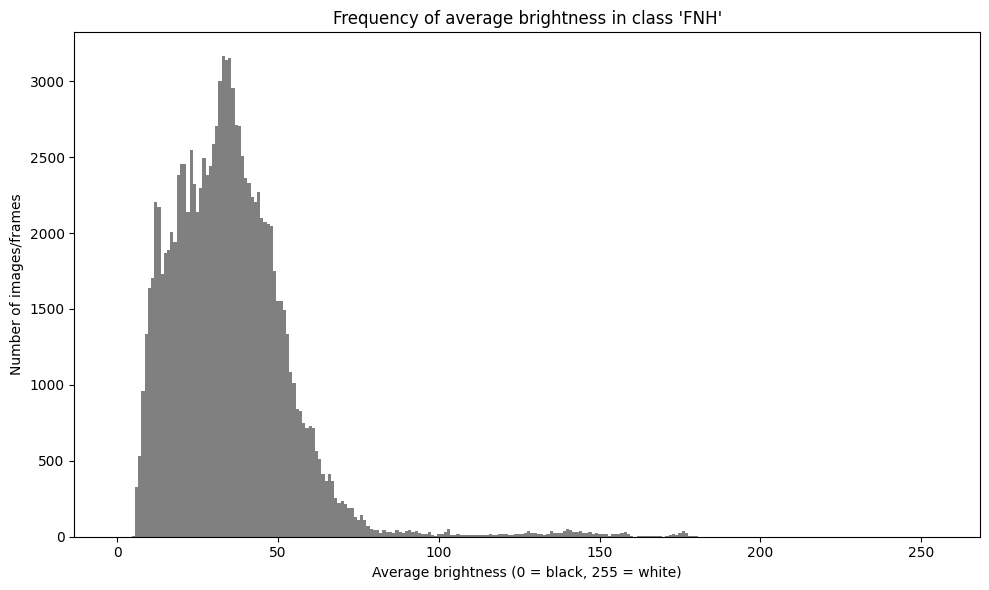

----------------------
Class 'HCC' has 218883 frames.
Average mean brightness for class 'HCC': 32.43
Average speckle index for class 'HCC': 1.54
Patients in class 'HCC': 67


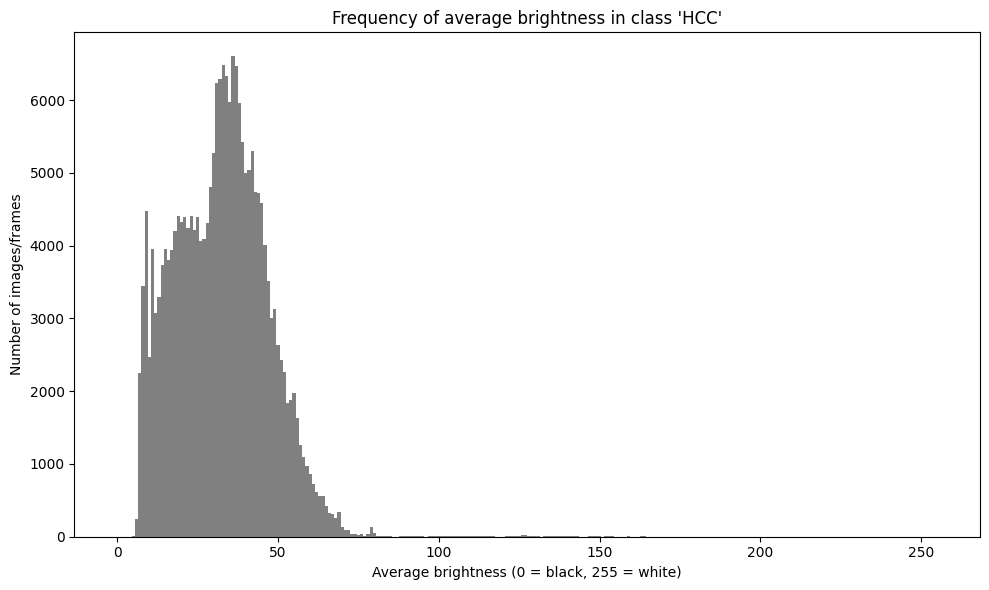

----------------------
Class 'Hemangioma' has 298394 frames.
Average mean brightness for class 'Hemangioma': 33.06
Average speckle index for class 'Hemangioma': 1.57
Patients in class 'Hemangioma': 149


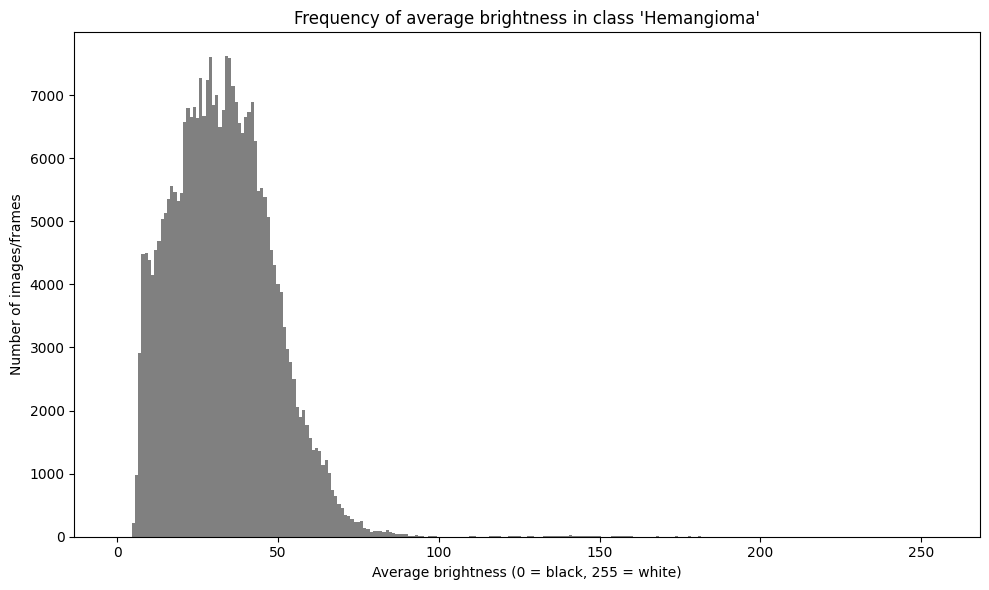

----------------------
Class 'Metastasis' has 323028 frames.
Average mean brightness for class 'Metastasis': 34.57
Average speckle index for class 'Metastasis': 1.48
Patients in class 'Metastasis': 102


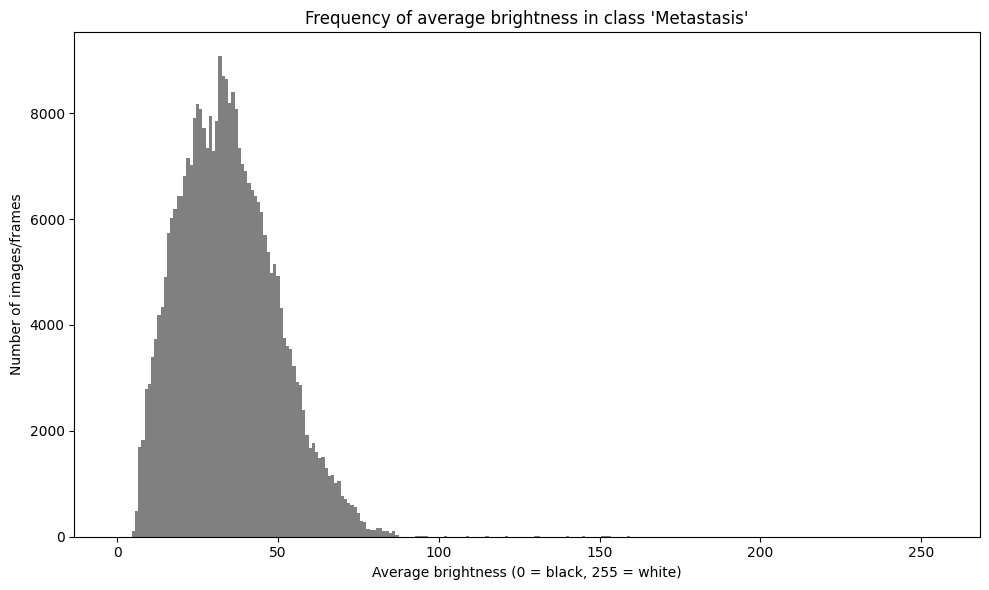

----------------------


In [131]:
process_all_datasets()

# Get into the details

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import itertools
import pandas as pd # Added for type hinting and potential use later

# Helper function (your original function, translated and refined)
def _plot_and_test_metric_core(metric_groups, group_labels, metric_name, y_label, y_lim_plot=None):
    """
    Creates a violin plot and performs statistical tests for a given metric.
    This is the core plotting and testing logic.
    """
    num_groups_initial = len(metric_groups) # Number of groups initially passed

    # Filter out groups that are entirely NaN or empty, and their labels
    # This is important for plotting and consistent test application
    valid_indices = [
        i for i, data in enumerate(metric_groups)
        if data is not None and len(np.array(data)[~np.isnan(np.array(data))]) > 0
    ]

    if not valid_indices:
        print(f"No valid data for {metric_name} to plot or test after filtering empty/NaN groups.")
        return

    metric_groups_plot = [metric_groups[i] for i in valid_indices]
    group_labels_plot = [group_labels[i] for i in valid_indices]
    num_groups_plot = len(metric_groups_plot) # Number of groups to be plotted

    if num_groups_plot == 0: # Should be caught by the 'if not valid_indices' above, but as a safeguard
        print(f"No valid data for {metric_name} to plot or test.")
        return

    # Dynamic palette
    palette = sns.color_palette("viridis", n_colors=num_groups_plot)

    print(f"\n--- Violin Plot of {metric_name} ---")
    plt.figure(figsize=(max(6, 3 * num_groups_plot), 6))
    # For violinplot, it's often better to pass data that might still contain NaNs,
    # as seaborn can handle them. We pass metric_groups_plot which contains original data for valid groups.
    # `cut=0` ensures the violin doesn't extend beyond the data range.
    sns.violinplot(data=metric_groups_plot, palette=palette, cut=0)
    plt.xticks(np.arange(num_groups_plot), group_labels_plot, rotation=45, ha="right")
    plt.title(f"Distribution of {metric_name}")
    plt.ylabel(y_label)
    plt.xlabel("Group / Dataset") # Changed from "Datensatz"
    if y_lim_plot:
        plt.ylim(y_lim_plot)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Statistical Tests ---
    # Use data prepared for testing (NaNs removed where necessary by the stats functions themselves or manually)
    # For Kruskal-Wallis and subsequent pairwise, we need lists of 1D arrays without NaNs.
    # For Mann-Whitney U on two groups, nan_policy='omit' handles it.

    if num_groups_plot == 1:
        print(f"\nOnly one group with sufficient data for {metric_name}. No statistical comparison performed.")
    elif num_groups_plot == 2:
        print(f"\n--- Statistical Test (Mann-Whitney U) for {metric_name} ---")
        # Data for Mann-Whitney U should be the raw data of the two groups, NaNs will be omitted by nan_policy
        group1_data_mw = metric_groups_plot[0]
        group2_data_mw = metric_groups_plot[1]
        try:
            # Check if groups have enough data after potential NaN omission by mannwhitneyu
            # This check is implicitly done by mannwhitneyu raising ValueError if one array is all NaNs or empty
            u_statistic, p_value = stats.mannwhitneyu(group1_data_mw, group2_data_mw, alternative='two-sided', nan_policy='omit')
            print(f"Mann-Whitney U Test between '{group_labels_plot[0]}' and '{group_labels_plot[1]}':")
            print(f"  U-Statistic: {u_statistic:.4f}")
            print(f"  P-Value: {p_value:.4f}")
            if p_value < 0.05:
                print("  There is a statistically significant difference (p < 0.05).")
            else:
                print("  No statistically significant difference (p >= 0.05).")
        except ValueError as e:
            print(f"  Could not perform Mann-Whitney U Test: {e}")
            print("  This might be due to one or both groups having no valid data after NaN omission.")
    elif num_groups_plot > 2:
        print(f"\n--- Statistical Test (Kruskal-Wallis H) for {metric_name} ---")
        # For Kruskal-Wallis, input must be NaN-free arrays.
        # metric_groups_plot still contains the original data (incl. NaNs) for the valid groups.
        # We need to create NaN-free versions for Kruskal-Wallis.
        kruskal_data_groups = [np.array(g)[~np.isnan(np.array(g))] for g in metric_groups_plot]
        # Further filter out any group that became empty after NaN removal ONLY for Kruskal
        kruskal_data_ready = [g for g in kruskal_data_groups if len(g) > 0]
        # Get corresponding labels for the groups that are ready for Kruskal
        kruskal_labels_ready = [group_labels_plot[i] for i, g in enumerate(kruskal_data_groups) if len(g) > 0]


        if len(kruskal_data_ready) < 2:
             print(f"  Not enough groups with valid data for Kruskal-Wallis Test for {metric_name} after NaN removal.")
             return # Exit if not enough groups for Kruskal

        try:
            h_statistic, p_value_kruskal = stats.kruskal(*kruskal_data_ready)
            print(f"Kruskal-Wallis H Test across {len(kruskal_data_ready)} valid groups for {metric_name}:")
            print(f"  (Groups included: {', '.join(kruskal_labels_ready)})")
            print(f"  H-Statistic: {h_statistic:.4f}")
            print(f"  P-Value: {p_value_kruskal:.4f}")

            if p_value_kruskal < 0.05:
                print("  There is a statistically significant difference among at least two groups (p < 0.05).")
                print("  Performing pairwise Mann-Whitney U tests with Bonferroni correction:")

                num_valid_groups_for_posthoc = len(kruskal_data_ready)
                num_comparisons = num_valid_groups_for_posthoc * (num_valid_groups_for_posthoc - 1) / 2
                if num_comparisons == 0: # Should not happen if p_kruskal < 0.05 and len > 1
                    print("  No comparisons to make for post-hoc.")
                    return

                alpha_bonferroni = 0.05 / num_comparisons
                print(f"  Number of pairwise comparisons: {int(num_comparisons)}")
                print(f"  Significance level after Bonferroni (alpha'): {alpha_bonferroni:.6f}")

                significant_pairs = []
                # Iterate over combinations of indices of the groups used in Kruskal-Wallis
                for i_idx, j_idx in itertools.combinations(range(num_valid_groups_for_posthoc), 2):
                    # Data for these groups is already NaN-free from kruskal_data_ready
                    group_i_data_ph = kruskal_data_ready[i_idx]
                    group_j_data_ph = kruskal_data_ready[j_idx]
                    label_i_ph = kruskal_labels_ready[i_idx]
                    label_j_ph = kruskal_labels_ready[j_idx]

                    # These groups must have data because they were part of kruskal_data_ready
                    # (which filtered out empty ones)
                    try:
                        # No nan_policy needed as data is pre-cleaned
                        u_stat, p_val_mw = stats.mannwhitneyu(group_i_data_ph, group_j_data_ph, alternative='two-sided')
                        print(f"  - Comparing '{label_i_ph}' vs. '{label_j_ph}': P-value = {p_val_mw:.4f}", end="")
                        if p_val_mw < alpha_bonferroni:
                            print(" (Significant after Bonferroni)")
                            significant_pairs.append((label_i_ph, label_j_ph))
                        else:
                            print(" (Not significant after Bonferroni)")
                    except ValueError as e_mw:
                         # This should ideally not happen if kruskal_data_ready was prepared correctly
                         print(f"  - Comparing '{label_i_ph}' vs. '{label_j_ph}': Could not perform test ({e_mw})")
                
                if not significant_pairs:
                    print("  No pairs found to be significantly different after Bonferroni correction.")
                else:
                    print(f"\n  Significant pairs for {metric_name} (p < {alpha_bonferroni:.6f}): {significant_pairs}")

            else:
                print("  No statistically significant difference among the groups (p >= 0.05).")
        except ValueError as e:
            print(f"  Could not perform Kruskal-Wallis H Test: {e}")
            print("  This might be due to insufficient data in groups after NaN removal.")


def plot_and_analyze_metric_from_df(
    df: pd.DataFrame,
    metric_column: str,
    group_by_column: str,
    y_label: str = None,
    y_lim_plot: tuple = None,
    title_metric_name: str = None,
    filter_dict: dict = None
):
    """
    Extracts data from a DataFrame based on a grouping column and a metric column,
    then calls the core plotting and testing function.

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric_column (str): The name of the column containing the numerical metric to analyze.
        group_by_column (str): The name of the column to use for grouping the data.
        y_label (str, optional): Label for the y-axis. If None, uses metric_column.
        y_lim_plot (tuple, optional): Tuple (min, max) for y-axis limits.
        title_metric_name (str, optional): Name of the metric for titles. If None, uses metric_column.
        filter_dict (dict, optional): A dictionary to pre-filter the DataFrame.
                                      Example: {'column_name': 'value_to_keep'} or
                                               {'column_name': ['value1', 'value2']}
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if metric_column not in df.columns:
        raise ValueError(f"Metric column '{metric_column}' not found in DataFrame.")
    if group_by_column not in df.columns:
        raise ValueError(f"Group-by column '{group_by_column}' not found in DataFrame.")

    # --- 1. Pre-filter DataFrame if filter_dict is provided ---
    df_processed = df.copy()
    if filter_dict:
        print(f"Applying filters: {filter_dict}")
        for col, value in filter_dict.items():
            if col not in df_processed.columns:
                print(f"Warning: Filter column '{col}' not found in DataFrame. Skipping this filter.")
                continue
            if isinstance(value, list):
                df_processed = df_processed[df_processed[col].isin(value)]
            else:
                df_processed = df_processed[df_processed[col] == value]
        if df_processed.empty:
            print("DataFrame is empty after applying filters. No analysis will be performed.")
            return

    # --- 2. Prepare data for plotting and testing ---
    # Drop rows where the group_by_column OR metric_column is NaN, as they can't be grouped or used.
    # NaNs within a group's metric data will be handled by the core function or stats tests.
    df_analysis = df_processed.dropna(subset=[group_by_column, metric_column]).copy()
    
    if df_analysis.empty:
        print(f"No data available for metric '{metric_column}' and group '{group_by_column}' after removing essential NaNs.")
        return

    # Get unique group values and sort them for consistent order
    # Convert to string to handle mixed types and for consistent labeling
    unique_groups = sorted([str(g) for g in df_analysis[group_by_column].unique()])

    if not unique_groups:
        print(f"No unique groups found in column '{group_by_column}' after filtering.")
        return

    metric_groups_data = []
    group_labels_final = []

    for group_val_str in unique_groups:
        # Need to match group_val_str back to original data types if necessary,
        # or ensure group_by_column is also string type for reliable comparison.
        # Easiest is to convert the df[group_by_column] to string for this step:
        current_group_data = df_analysis[df_analysis[group_by_column].astype(str) == group_val_str][metric_column]
        
        # We pass the Series directly (or .values for numpy array).
        # The core function's initial filtering will handle if it's all NaN.
        if not current_group_data.empty: # Ensure Series is not empty
            metric_groups_data.append(current_group_data.values) # Pass as numpy array
            group_labels_final.append(group_val_str)
        # If current_group_data is empty (e.g., all NaNs were dropped from metric_column for this group earlier)
        # it won't be added, which is correct.

    if not metric_groups_data:
        print(f"No data found for any group in '{group_by_column}' for metric '{metric_column}'.")
        return

    # Determine y_label and metric_name for titles
    final_y_label = y_label if y_label else metric_column.replace("_", " ").title()
    final_metric_name = title_metric_name if title_metric_name else metric_column.replace("_", " ").title()

    # Call the core plotting and testing function
    _plot_and_test_metric_core(
        metric_groups=metric_groups_data,
        group_labels=group_labels_final,
        metric_name=final_metric_name,
        y_label=final_y_label,
        y_lim_plot=y_lim_plot
    )

def compare_metric_between_two_datasets_by_subgroup(
    df: pd.DataFrame,
    metric_column: str,
    dataset_identifier_col: str, # e.g., 'dataset' in your example
    datasets_to_compare: list,   # A list of two dataset names, e.g., ['name_dataset_1', 'name_dataset_2']
    subgroup_col: str,           # The column for sub-grouping, e.g., 'class'
    y_label: str = None,
    y_lim_plot: tuple = None,
    base_title_metric_name: str = None # Will be used to construct titles
):
    """
    Compares a metric between two specific datasets, subgrouped by another column (e.g., 'class').
    For each common subgroup, it generates a separate plot and statistical test comparing the two datasets.

    Args:
        df (pd.DataFrame): The input DataFrame (can be a concatenation of multiple original DFs).
        metric_column (str): The name of the column containing the numerical metric.
        dataset_identifier_col (str): The column name that identifies the source dataset.
        datasets_to_compare (list): A list containing the names of the TWO datasets to compare.
                                    Example: ['DS1', 'DS2']
        subgroup_col (str): The column name to use for subgrouping within each dataset (e.g., 'class').
        y_label (str, optional): Label for the y-axis. If None, uses metric_column.
        y_lim_plot (tuple, optional): Tuple (min, max) for y-axis limits.
        base_title_metric_name (str, optional): Base name for metric in titles. If None, uses metric_column.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if metric_column not in df.columns:
        raise ValueError(f"Metric column '{metric_column}' not found in DataFrame.")
    if dataset_identifier_col not in df.columns:
        raise ValueError(f"Dataset identifier column '{dataset_identifier_col}' not found.")
    if subgroup_col not in df.columns:
        raise ValueError(f"Subgroup column '{subgroup_col}' not found.")
    if not isinstance(datasets_to_compare, list) or len(datasets_to_compare) != 2:
        raise ValueError("'datasets_to_compare' must be a list containing exactly two dataset names.")

    ds_name1, ds_name2 = datasets_to_compare

    # 1. Filter DataFrame for the two selected datasets
    df_filtered = df[df[dataset_identifier_col].isin(datasets_to_compare)].copy()
    if df_filtered.empty:
        print(f"No data found for the specified datasets: {datasets_to_compare}")
        return

    # Convert subgroup column to string for reliable comparison and labeling, and get unique values
    df_filtered[subgroup_col] = df_filtered[subgroup_col].astype(str)
    
    # 2. Find common subgroups (e.g., classes) present in BOTH datasets
    subgroups_ds1 = set(df_filtered[df_filtered[dataset_identifier_col] == ds_name1][subgroup_col].unique())
    subgroups_ds2 = set(df_filtered[df_filtered[dataset_identifier_col] == ds_name2][subgroup_col].unique())
    
    common_subgroups = sorted(list(subgroups_ds1.intersection(subgroups_ds2)))

    if not common_subgroups:
        print(f"No common subgroups ('{subgroup_col}') found between '{ds_name1}' and '{ds_name2}'.")
        return

    print(f"\n--- Comparing metric '{metric_column}' between '{ds_name1}' and '{ds_name2}' for common subgroups in '{subgroup_col}' ---")

    final_y_label = y_label if y_label else metric_column.replace("_", " ").title()
    title_metric_base = base_title_metric_name if base_title_metric_name else metric_column.replace("_", " ").title()

    # 3. Iterate through common subgroups and perform comparison
    for subgroup_value in common_subgroups:
        print(f"\n=== Subgroup: {subgroup_col} = {subgroup_value} ===")

        # Extract data for dataset 1, current subgroup
        data_ds1_subgroup = df_filtered[
            (df_filtered[dataset_identifier_col] == ds_name1) &
            (df_filtered[subgroup_col] == subgroup_value)
        ][metric_column].dropna() # Drop NaNs from the metric column for this specific group

        # Extract data for dataset 2, current subgroup
        data_ds2_subgroup = df_filtered[
            (df_filtered[dataset_identifier_col] == ds_name2) &
            (df_filtered[subgroup_col] == subgroup_value)
        ][metric_column].dropna()

        # Check if we have enough data in both groups for this subgroup
        if data_ds1_subgroup.empty or data_ds2_subgroup.empty:
            print(f"  Not enough data for subgroup '{subgroup_value}' in one or both datasets. Skipping comparison.")
            if data_ds1_subgroup.empty:
                print(f"    Data for '{ds_name1}' - '{subgroup_value}' is empty or all NaN.")
            if data_ds2_subgroup.empty:
                print(f"    Data for '{ds_name2}' - '{subgroup_value}' is empty or all NaN.")
            continue

        metric_groups_for_core = [data_ds1_subgroup.values, data_ds2_subgroup.values]
        group_labels_for_core = [f"{ds_name1}\n({subgroup_value})", f"{ds_name2}\n({subgroup_value})"]
        
        current_plot_title = f"{title_metric_base} for {subgroup_col} '{subgroup_value}'"

        # Call the core plotting and testing function
        # Since we are always passing exactly two groups here, it will always use Mann-Whitney U
        _plot_and_test_metric_core(
            metric_groups=metric_groups_for_core,
            group_labels=group_labels_for_core,
            metric_name=current_plot_title, # Use a more descriptive name for the overall plot title
            y_label=final_y_label,
            y_lim_plot=y_lim_plot
        )


--- Violin Plot of pixel numbers ---


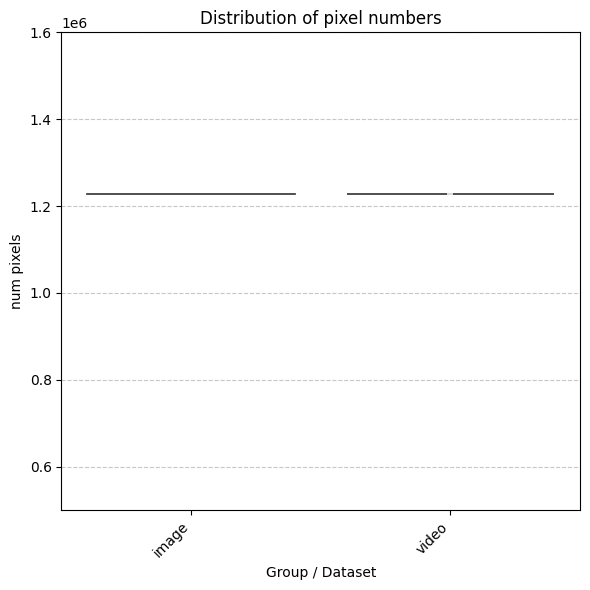


--- Statistical Test (Mann-Whitney U) for pixel numbers ---
Mann-Whitney U Test between 'image' and 'video':
  U-Statistic: 11462257822.5000
  P-Value: 1.0000
  No statistically significant difference (p >= 0.05).


In [171]:
df = pd.read_csv('/home/janik/Documents/scripts/Image_Dataset_Statistics/Image-Dataset-Statistics/US_DATA_PSEUDO_summary.csv')

# import pandas as pd
# import os

# # Liste der CSV-Dateien
# csv_paths = [
#     "/home/janik/Documents/scripts/Image_Dataset_Statistics/Image-Dataset-Statistics/name_dataset_1_summary.csv",
#     "/home/janik/Documents/scripts/Image_Dataset_Statistics/Image-Dataset-Statistics/name_dataset_2_summary.csv"
# ]

# # Alle einlesen und in einer Liste speichern
# dfs = [pd.read_csv(path) for path in csv_paths]

# # Zu einem DataFrame zusammenführen
# combined_df = pd.concat(dfs, ignore_index=True)


plot_and_analyze_metric_from_df(
    df=df,
    metric_column="num_pixels",
    group_by_column="filetype",
    y_label="num pixels",
    y_lim_plot= (500000,1600000),
    title_metric_name="pixel numbers",  # or any other name you prefer
    filter_dict=None  # oder z. B. {"dataset": "DUS"}
)


Frames per Patient

/tmp/ipykernel_18889/3004887731.py:8: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(


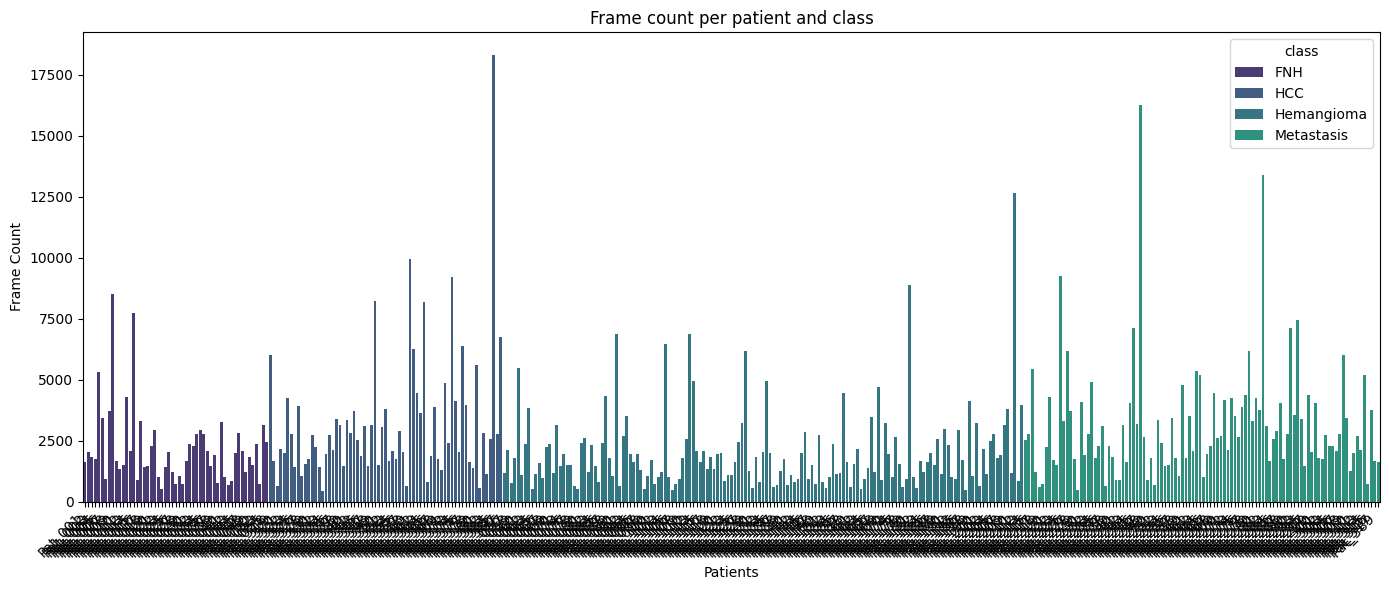

In [ ]:
palette = sns.color_palette("viridis")
df_grouped = df.groupby(["class", "pat"]).size().reset_index(name="frame_count")
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_grouped,
    x="pat",
    y="frame_count",
    hue="class",
    palette=palette
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Patients")
plt.ylabel("Frame Count")
plt.title("Frame count per patient and class")
plt.tight_layout()
plt.show()